In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastai.imports import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from pandas.api.types import is_string_dtype
import pyarrow
import numpy as np
from sklearn.tree import export_graphviz
import IPython, graphviz
from sklearn.ensemble import forest

In [3]:
PATH = "/Users/bablu/Downloads/competitive-data-science-predict-future-sales/"

In [4]:
df_raw = pd.read_csv(f'{PATH}sales_train.csv', low_memory=False, parse_dates=['date'])
df_items = pd.read_csv(f'{PATH}items.csv', low_memory=False)
df_item_cat = pd.read_csv(f'{PATH}item_categories.csv', low_memory=False)
df_shops = pd.read_csv(f'{PATH}shops.csv', low_memory=False)

In [5]:
df_raw['date'] = df_raw['date'].apply(lambda x: x.strftime('%Y-%m'))

In [6]:
df = df_raw.groupby(['date','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date', 
                    values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)

In [7]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [8]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [9]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

In [10]:
train_cats(df)

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)
display_all(df.isnull().sum().sort_index()/len(df))

date
2013-01    0.0
2013-02    0.0
2013-03    0.0
2013-04    0.0
2013-05    0.0
2013-06    0.0
2013-07    0.0
2013-08    0.0
2013-09    0.0
2013-10    0.0
2013-11    0.0
2013-12    0.0
2014-01    0.0
2014-02    0.0
2014-03    0.0
2014-04    0.0
2014-05    0.0
2014-06    0.0
2014-07    0.0
2014-08    0.0
2014-09    0.0
2014-10    0.0
2014-11    0.0
2014-12    0.0
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
2015-06    0.0
2015-07    0.0
2015-08    0.0
2015-09    0.0
2015-10    0.0
2015-11    0.0
2015-12    0.0
item_id    0.0
shop_id    0.0
dtype: float64

In [12]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424124 entries, 0 to 424123
Data columns (total 38 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   shop_id  424124 non-null  int64
 1   item_id  424124 non-null  int64
 2   2013-01  424124 non-null  int64
 3   2013-02  424124 non-null  int64
 4   2013-03  424124 non-null  int64
 5   2013-04  424124 non-null  int64
 6   2013-05  424124 non-null  int64
 7   2013-06  424124 non-null  int64
 8   2013-07  424124 non-null  int64
 9   2013-08  424124 non-null  int64
 10  2013-09  424124 non-null  int64
 11  2013-10  424124 non-null  int64
 12  2013-11  424124 non-null  int64
 13  2013-12  424124 non-null  int64
 14  2014-01  424124 non-null  int64
 15  2014-02  424124 non-null  int64
 16  2014-03  424124 non-null  int64
 17  2014-04  424124 non-null  int64
 18  2014-05  424124 non-null  int64
 19  2014-06  424124 non-null  int64
 20  2014-07  424124 non-null  int64
 21  2014-08  424124 non-null  int64
 

In [14]:
df1, y, nas = proc_df(df, '2015-12')

In [15]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 120000 
n_trn = len(df1)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df1, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((304124, 37), (304124,), (120000, 37))

In [16]:
ens = TreeEnsemble(X_train, y_train, 5, 1000)

In [17]:
preds = ens.predict(X_valid.values)

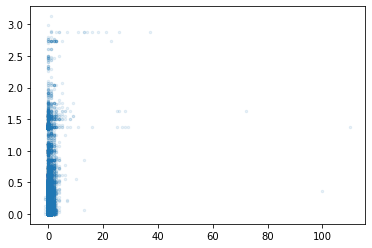

In [18]:
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [19]:
metrics.r2_score(y_valid, preds)

0.02123096248364298

In [20]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_valid, preds, squared=False)

In [21]:
rms

0.6136121812691793

In [32]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [33]:
df_test = pd.merge(df_test, df, on=['shop_id', 'item_id'], how= 'left')

In [34]:
df_test = df_test.fillna(0)

In [35]:
df2, y, nas = proc_df(df_test, '2015-12')

In [36]:
df2.shape

(214200, 38)

In [37]:
y.shape

(214200,)

In [38]:
X_test = df2

In [39]:
preds_02 = ens.predict(X_test.values)

In [40]:
rms = mean_squared_error(y, preds_02, squared=False)
rms

0.70047421706926

In [41]:
submission = list(map(round, preds_02))

In [42]:
df_sample = pd.read_csv(f'{PATH}sample_submission.csv', low_memory=False)

In [43]:
df_sample.shape

(214200, 2)

In [44]:
df_sample['item_cnt_month'] = preds_02
df_sample.to_csv('submission.csv', index=False)
df_sample.head()

,ID,item_cnt_month
0,0,0.233333
1,1,0.000000
2,2,0.100000
3,3,0.000000
4,4,0.000000
